In [ ]:
!pip install celluloid

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from zipfile import ZipFile

from celluloid import Camera
from tqdm import trange

from scipy.stats import ttest_ind_from_stats

# ***Implement DE***

In [54]:
def de(fobj, bounds, F_scale=0.8, cross_prob=0.7, popsize=20, max_evals=1e5, seed_number=20521482):
    np.random.seed(seed_number)
    
    dimensions = len(bounds)
    lower_bound, upper_bound = np.asarray(bounds).T
    
    diff = np.fabs(lower_bound - upper_bound)
    
    pop = lower_bound + diff * np.random.rand(popsize, dimensions)

    fitness = np.asarray([fobj(ind) for ind in pop])
    count = len(pop)
  
    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []
    all_pops = []
    
    generation_count = 0
    while True:
        if count > max_evals:
            break
        results.append((np.copy(best), fitness[best_idx], count))
        
        all_pops.append(np.copy(pop))
        for j in range(popsize):
          idxs = [idx for idx in range(popsize) if idx != j]
          a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
          mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

          cross_points = np.random.rand(dimensions) < cross_prob
          if not np.any(cross_points):
              cross_points[np.random.randint(0, dimensions)] = True

          trial = np.where(cross_points, mutant, pop[j])

          f = fobj(trial)
          count += 1
          if f < fitness[j]:
              fitness[j] = f
              pop[j] = trial
              if f < fitness[best_idx]:
                  best_idx = j
                  best = trial

        generation_count += 1

    return results, all_pops, generation_count


# ***Implement improved version of CEM***

In [55]:
def CEMiv(fobj, bounds, popsize, num_elite, sigma_init, extra_std, seed_number, max_evals):
    np.random.seed(seed_number)
    dimensions = len(bounds)
    lower_bound, upper_bound = np.asarray(bounds).T
    sigma = sigma_init * np.eye(dimensions)
    
    #w = 1/num_elite
    weights = np.array([np.log(num_elite+1)-np.log(i+1) for i in range(num_elite)])
    w = weights / np.sum(weights)
    diff = np.fabs(lower_bound - upper_bound)
    count = 0
    count_list = []
    mu = lower_bound + diff*np.random.rand(dimensions)
    generation_count = 0
    all_mu = []
    all_pops = []
    all_fitness = []
    results = []
    
    while True:
        if count > max_evals: 
            break
            
        all_mu.append(mu)

        x = np.random.multivariate_normal(mu, sigma, popsize)
        x = np.clip(x,lower_bound[0],upper_bound[0])
        all_pops.append(np.copy(x))
        
        fitness = np.array([fobj(ind) for ind in x])
        count += popsize

        count_list.append(count)
        generation_count += 1
        
        best_idx = np.argmin(fitness)
        best = x[best_idx]
        results.append(best)
        
        best_fitness = min(fitness) 
        all_fitness.append(best_fitness)
        
        elite_idx = fitness.argsort()[:num_elite]
        
        sigma = np.zeros_like(sigma)
        mu_1 = np.zeros_like(mu)
        
        for i in range(num_elite): 
            z = x[elite_idx[i]] - mu
            z = z.reshape(-1, 1)
            sigma += (w[i]* (z @ z.T))
            mu_1 += w[i]*x[elite_idx[i]]
        sigma += np.eye(dimensions)*extra_std
        
        mu = np.copy(mu_1)
        
        
    return results, all_fitness, all_pops, count_list, generation_count

# ***Implement Sphere Function***

In [56]:
def SphereFunction(z):#xi ∈ [-5.12,5.12]
  res = 0
  for i in z:
    res += i**2 

  return res

# ***Implement Zakharov Function***

In [57]:
def ZakharovFunction(z):#xi ∈ [-5, 10]
  first = 0
  for i in z:
    first += i**2 

  second = 0
  for i in range(len(z)):
    second += (0.5 * (i+1) * z[i])

  second = np.square(second) 
  res = first + second + np.square(second)

  return res

# ***Implement Rosenbrock Function***

In [58]:
def RosenbrockFunction(z): #xi ∈ [-5,10]
  res = 0
  for i in range(len(z) - 1):
    res += (100 * (z[i + 1] - z[i]**2)**2 + (z[i] - 1)**2)

  return res

# ***Implement Michalewicz Function***

In [59]:
def MichalewiczFunction(z): #xi ∈ [0,pi]
  m = 10
  res = 0
  for i in range(len(z)):
    first = np.sin(z[i])
    second = (np.sin(((i+1) * np.square(z[i])) / np.pi) ** (2*m))
    res += (first * second)

  return -res

# ***Implement Ackley Function***

In [60]:
def AckleyFunction(z): #xi ∈ [-32.768, 32.768]
    a = 20
    b = 0.2
    c = 2 * np.pi
    res1, res2 = 0, 0
    for i in range(len(z)):
        res1 += z[i] ** 2
        res2 += np.cos(c * z[i])
    temp1 = -a * np.exp(-b * np.sqrt(res1 / len(z)))
    temp2 = -np.exp(res2 / len(z))

    return temp1 + temp2 + a + np.exp(1)

In [61]:
bounds_dict = {"Sphere": [(-5.12,5.12)],
               "Zakharov": [(-5,10)],
               "Rosenbrock": [(-5,10)],
               "Michalewicz": [(0,np.pi)],
               "Ackley": [(-32.768, 32.768)]}

In [62]:
global_minimum = {"Sphere": [0,0],
                  "Zakharov": [0,0],
                  "Rosenbrock": [1,1],
                  "Michalewicz": [2.20,1.57],
                  "Ackley": [0,0]}

In [63]:
N = np.array([32, 64, 128, 256, 512, 1024])

In [8]:
seed = 20521482

In [122]:
sentence = 'best,                              fitness_best,      count'

# ***Differential Evolution Algorithm***

## ***SphereFunction***

 **d = 2**

In [ ]:
file = 'SphereFunction2.zip'
for n in N:
  for i in range(10):
    results, all_pops, generation_count = de(SphereFunction, bounds=bounds_dict["Sphere"]*2, popsize=n, max_evals=1e5, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [202]:
file = 'SphereFunction10.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(SphereFunction, bounds=bounds_dict["Sphere"]*10, popsize=n, max_evals=1e6, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


KeyboardInterrupt: 

## ***ZakharovFunction***

**d = 2**

In [490]:
file = 'ZakharovFunction2.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(ZakharovFunction, bounds=bounds_dict["Zakharov"]*2, popsize=n, max_evals=1e5, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [487]:
file = 'ZakharovFunction10.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(ZakharovFunction, bounds=bounds_dict["Zakharov"]*10, popsize=n, max_evals=1e6, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


## ***RosenbrockFunction***

**d = 2**

In [50]:
file = 'RosenbrockFunction2.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*2, popsize=n, max_evals=1e5, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [51]:
file = 'RosenbrockFunction10.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*10, popsize=n, max_evals=1e6, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)

## ***MichalewiczFunction***

**d = 2**

In [488]:
file = 'MichalewiczFunction2.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*2, popsize=n, max_evals=1e5, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [489]:
file = 'MichalewiczFunction10.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*10, popsize=n, max_evals=1e6, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


## ***AckleyFunction***

**d = 2**

In [ ]:
file = 'AckleyFunction2.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(AckleyFunction, bounds=bounds_dict["Ackley"]*2, popsize=n, max_evals=1e5, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [ ]:
file = 'AckleyFunction10.zip'
for n in N:
  for i in range(10):
    results, all_pops, count = de(AckleyFunction, bounds=bounds_dict["Ackley"]*10, popsize=n, max_evals=1e6, seed_number = seed + i)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for line in results:
          f.write(str(line))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


# ***Cross Entropy Method (Improved version)***

## ***SphereFunction***

 **d = 2**

In [1826]:
file = 'SphereFunction2.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(SphereFunction, bounds_dict["Sphere"]*2, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.01, seed_number = seed + i, max_evals = 1e5)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      f.write(sentence)
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [1827]:
file = 'SphereFunction10.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(SphereFunction, bounds=bounds_dict["Sphere"]*10, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e6)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


## ***ZakharovFunction***

**d = 2**

In [1828]:
file = 'ZakharovFunction2.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(ZakharovFunction, bounds=bounds_dict["Zakharov"]*2, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.01, seed_number = seed + i, max_evals = 1e5)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [1829]:
file = 'ZakharovFunction10.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(ZakharovFunction, bounds=bounds_dict["Zakharov"]*10, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e6)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


## ***RosenbrockFunction***

**d = 2**

In [1830]:
file = 'RosenbrockFunction2.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*2, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.01, seed_number = seed + i, max_evals = 1e5)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [1831]:
file = 'RosenbrockFunction10.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*10, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e6)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)

## ***MichalewiczFunction***

**d = 2**

In [1832]:
file = 'MichalewiczFunction2.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*2, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.01, seed_number = seed + i, max_evals = 1e5)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [1833]:
file = 'MichalewiczFunction10.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*10, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e6)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


## ***AckleyFunction***

**d = 2**

In [1834]:
file = 'AckleyFunction2.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(AckleyFunction, bounds=bounds_dict["Ackley"]*2, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e5)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


**d = 10**

In [1835]:
file = 'AckleyFunction10.zip'
for n in N:
  for i in range(10):
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(AckleyFunction, bounds=bounds_dict["Ackley"]*10, popsize = n, num_elite = n//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = 1e6)
    file_name = 'results{}_{}.txt'.format(n,i)
    with open(file_name, 'w') as f:
      f.write(sentence)
      f.write('\n')
      f.write('seed: ' + str(seed) + " + " + str(i))
      f.write('\n')
      for i in range(len(results)):
          f.write(str(results[i]) + " " + str(all_fitness[i]) + " " + str(count_list[i]))
          f.write('\n')
    with ZipFile(file, 'a') as z:
      z.write(file_name)


# ***Convergence graph***

In [65]:
def plt_DE(fobj, bounds, popsize, max_evals=1e5, seed_number = 20521482):
    all_results = []

    for i in range(10):
        results, all_pops, generation_count = de(fobj=fobj, bounds=bounds, popsize=popsize, max_evals=max_evals, seed_number = seed_number + i)
        all_results.append(results)
    
    plt_fitness = []
    plt_std = []
    plt_count = []
    for i in range(len(all_results[0])):
        fitness = []
        count = []
        for j in range(10):
            fitness.append(all_results[j][i][1])
            count.append(all_results[j][i][2])
        plt_fitness.append(np.mean(fitness))
        plt_std.append(np.std(fitness))
        plt_count.append(np.mean(count))
    
    return plt_fitness,plt_std, plt_count

In [66]:
def plt_CEMiv(fobj, bounds, popsize, max_evals=1e5, seed_number = 20521482):
    all_results = []
    all_fitness = []
    all_count = []
    for i in range(10):
        results, fitness, all_pops, count_list, generation_count = CEMiv(fobj=fobj, bounds=bounds, popsize = popsize, num_elite = popsize//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = max_evals)
        all_results.append(results)
        all_fitness.append(fitness)
        all_count.append(count_list)
        
    plt_fitness = []
    plt_std = []
    plt_count = []
    for i in range(len(all_results[0])):
        fitness = []
        count = []
        for j in range(10):
            fitness.append(all_fitness[j][i])
            count.append(all_count[j][i])
        plt_fitness.append(np.mean(fitness))
        plt_std.append(np.std(fitness))
        plt_count.append(np.mean(count))
    
    return plt_fitness,plt_std, plt_count

In [75]:
def cal_error(mean,std):
    error = np.multiply(0.5,std)
    lower = mean - error
    upper = mean + error
    
    return lower, upper

## SphereFunction

**d = 2**

**DE Algorithm**

In [450]:
sphere_fitness_de_128, sphere_std_de_128, sphere_count_de_128 = plt_DE(SphereFunction, bounds = bounds_dict["Sphere"]*2,popsize=128)

In [452]:
sphere_fitness_de_1024, sphere_std_de_1024, sphere_count_de_1024 = plt_DE(SphereFunction, bounds = bounds_dict["Sphere"]*2,popsize=1024)

**CEM Improved Version Algorithm**

In [1524]:
sphere_fitness_CEMiv_128, sphere_std_CEMiv_128, sphere_count_CEMiv_128 = plt_CEMiv(SphereFunction, bounds = bounds_dict["Sphere"]*2,popsize=128)

In [1525]:
sphere_fitness_CEMiv_1024, sphere_std_CEMiv_1024, sphere_count_CEMiv_1024 = plt_CEMiv(SphereFunction, bounds = bounds_dict["Sphere"]*2,popsize=1024)

**d = 10**

**DE Algorithm**

In [523]:
sphere_fitness_de_128_10, sphere_std_de_128_10, sphere_count_de_128_10 = plt_DE(SphereFunction, bounds = bounds_dict["Sphere"]*10,max_evals=1e6, popsize=128)

In [524]:
sphere_fitness_de_1024_10, sphere_std_de_1024_10, sphere_count_de_1024_10 = plt_DE(SphereFunction, bounds = bounds_dict["Sphere"]*10, max_evals=1e6, popsize=1024)

**CEM Improved Version Algorithm**

In [1611]:
sphere_fitness_CEMiv_128_10, sphere_std_CEMiv_128_10, sphere_count_CEMiv_128_10 = plt_CEMiv(SphereFunction, bounds = bounds_dict["Sphere"]*10,max_evals=1e6, popsize=128)

In [1612]:
sphere_fitness_CEMiv_1024_10, sphere_std_CEMiv_1024_10, sphere_count_CEMiv_1024_10 = plt_CEMiv(SphereFunction, bounds = bounds_dict["Sphere"]*10, max_evals=1e6, popsize=1024)

## Zakharov Function

**d = 2**

**DE Algorithm**

In [460]:
zakharov_fitness_de_128, zakharov_std_de_128, zakharov_count_de_128 = plt_DE(ZakharovFunction, bounds = bounds_dict["Zakharov"]*2,popsize=128)

In [461]:
zakharov_fitness_de_1024, zakharov_std_de_1024, zakharov_count_de_1024 = plt_DE(ZakharovFunction, bounds = bounds_dict["Zakharov"]*2,popsize=1024)

**CEM Improved Version Algorithm**

In [1536]:
zakharov_fitness_CEMiv_128, zakharov_std_CEMiv_128, zakharov_count_CEMiv_128 = plt_CEMiv(ZakharovFunction, bounds = bounds_dict["Zakharov"]*2,popsize=128)

In [1537]:
zakharov_fitness_CEMiv_1024, zakharov_std_CEMiv_1024, zakharov_count_CEMiv_1024 = plt_CEMiv(ZakharovFunction, bounds = bounds_dict["Zakharov"]*2,popsize=1024)

**d = 10**

**DE Algorithm**

In [526]:
zakharov_fitness_de_128_10, zakharov_std_de_128_10, zakharov_count_de_128_10 = plt_DE(ZakharovFunction, bounds = bounds_dict["Zakharov"]*10, max_evals=1e6, popsize=128)

In [527]:
zakharov_fitness_de_1024_10, zakharov_std_de_1024_10, zakharov_count_de_1024_10 = plt_DE(ZakharovFunction, bounds = bounds_dict["Zakharov"]*10, max_evals=1e6, popsize=1024)

**CEM Improved Version Algorithm**

In [1613]:
zakharov_fitness_CEMiv_128_10, zakharov_std_CEMiv_128_10, zakharov_count_CEMiv_128_10 = plt_CEMiv(ZakharovFunction, bounds = bounds_dict["Zakharov"]*10, max_evals=1e6, popsize=128)

In [1614]:
zakharov_fitness_CEMiv_1024_10, zakharov_std_CEMiv_1024_10, zakharov_count_CEMiv_1024_10 = plt_CEMiv(ZakharovFunction, bounds = bounds_dict["Zakharov"]*10, max_evals=1e6, popsize=1024)

## Rosenbrock Function

**d = 2**

**DE Algorithm**

In [68]:
rosenbrock_fitness_de_128, rosenbrock_std_de_128, rosenbrock_count_de_128 = plt_DE(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*2,popsize=128)

In [69]:
rosenbrock_fitness_de_1024, rosenbrock_std_de_1024, rosenbrock_count_de_1024 = plt_DE(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*2,popsize=1024)

**CEM Improved Version Algorithm**

In [70]:
rosenbrock_fitness_CEMiv_128, rosenbrock_std_CEMiv_128, rosenbrock_count_CEMiv_128 = plt_CEMiv(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*2,popsize=128)

In [71]:
rosenbrock_fitness_CEMiv_1024, rosenbrock_std_CEMiv_1024, rosenbrock_count_CEMiv_1024 = plt_CEMiv(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*2,popsize=1024)

**d = 10**

**DE Algorithm**

In [528]:
rosenbrock_fitness_de_128_10, rosenbrock_std_de_128_10, rosenbrock_count_de_128_10 = plt_DE(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*10, max_evals=1e6, popsize=128)

In [529]:
rosenbrock_fitness_de_1024_10, rosenbrock_std_de_1024_10, rosenbrock_count_de_1024_10 = plt_DE(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*10, max_evals=1e6, popsize=1024)

**CEM Improved Version Algorithm**

In [1615]:
rosenbrock_fitness_CEMiv_128_10, rosenbrock_std_CEMiv_128_10, rosenbrock_count_CEMiv_128_10 = plt_CEMiv(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*10, max_evals=1e6, popsize=128)

In [1616]:
rosenbrock_fitness_CEMiv_1024_10, rosenbrock_std_CEMiv_1024_10, rosenbrock_count_CEMiv_1024_10 = plt_CEMiv(RosenbrockFunction, bounds = bounds_dict["Rosenbrock"]*10, max_evals=1e6, popsize=1024)

## Michalewicz Function

**d = 2**

**DE Algorithm**

In [79]:
michalewicz_fitness_de_128, michalewicz_std_de_128, michalewicz_count_de_128 = plt_DE(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*2,popsize=128)

In [80]:
michalewicz_fitness_de_1024, michalewicz_std_de_1024, michalewicz_count_de_1024 = plt_DE(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*2,popsize=1024)

**CEM Improved Version Algorithm**

In [81]:
michalewicz_fitness_CEMiv_128, michalewicz_std_CEMiv_128, michalewicz_count_CEMiv_128 = plt_CEMiv(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*2,popsize=128)

In [82]:
michalewicz_fitness_CEMiv_1024, michalewicz_std_CEMiv_1024, michalewicz_count_CEMiv_1024 = plt_CEMiv(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*2,popsize=1024)

**d = 10**

**DE Algorithm**

In [531]:
michalewicz_fitness_de_128_10, michalewicz_std_de_128_10, michalewicz_count_de_128_10 = plt_DE(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*10, max_evals = 1e6, popsize=128)

In [532]:
michalewicz_fitness_de_1024_10, michalewicz_std_de_1024_10, michalewicz_count_de_1024_10 = plt_DE(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*10, max_evals = 1e6, popsize=1024)

**CEM Improved Version Algorithm**

In [1617]:
michalewicz_fitness_CEMiv_128_10, michalewicz_std_CEMiv_128_10, michalewicz_count_CEMiv_128_10 = plt_CEMiv(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*10, max_evals = 1e6, popsize=128)

In [1618]:
michalewicz_fitness_CEMiv_1024_10, michalewicz_std_CEMiv_1024_10, michalewicz_count_CEMiv_1024_10 = plt_CEMiv(MichalewiczFunction, bounds = bounds_dict["Michalewicz"]*10, max_evals = 1e6, popsize=1024)

## Ackley Function

**d = 2**

**DE Algorithm**

In [466]:
ackley_fitness_de_128, ackley_std_de_128, ackley_count_de_128 = plt_DE(AckleyFunction, bounds = bounds_dict["Ackley"]*2,popsize=128)

In [467]:
ackley_fitness_de_1024, ackley_std_de_1024, ackley_count_de_1024 = plt_DE(AckleyFunction, bounds = bounds_dict["Ackley"]*2,popsize=1024)

**CEM Improved Version Algorithm**

In [1542]:
ackley_fitness_CEMiv_128, ackley_std_CEMiv_128, ackley_count_CEMiv_128 = plt_CEMiv(AckleyFunction, bounds = bounds_dict["Ackley"]*2,popsize=128)

In [1543]:
ackley_fitness_CEMiv_1024, ackley_std_CEMiv_1024, ackley_count_CEMiv_1024 = plt_CEMiv(AckleyFunction, bounds = bounds_dict["Ackley"]*2,popsize=1024)

**d = 10**

**DE Algorithm**

In [534]:
ackley_fitness_de_128_10, ackley_std_de_128_10, ackley_count_de_128_10 = plt_DE(AckleyFunction, bounds = bounds_dict["Ackley"]*10, max_evals = 1e6, popsize=128)

In [535]:
ackley_fitness_de_1024_10, ackley_std_de_1024_10, ackley_count_de_1024_10 = plt_DE(AckleyFunction, bounds = bounds_dict["Ackley"]*10, max_evals = 1e6, popsize=1024)

**CEM Improved Version Algorithm**

In [1619]:
ackley_fitness_CEMiv_128_10, ackley_std_CEMiv_128_10, ackley_count_CEMiv_128_10 = plt_CEMiv(AckleyFunction, bounds = bounds_dict["Ackley"]*10, max_evals = 1e6, popsize=128)

In [1620]:
ackley_fitness_CEMiv_1024_10, ackley_std_CEMiv_1024_10, ackley_count_CEMiv_1024_10 = plt_CEMiv(AckleyFunction, bounds = bounds_dict["Ackley"]*10, max_evals = 1e6, popsize=1024)

## **Graph**

### DE Algorithm

#### Sphere Function

#### d = 2

In [1629]:
lower_sphere_de_128, upper_sphere_de_128 = cal_error(sphere_fitness_de_128,sphere_std_de_128)
lower_sphere_de_1024, upper_sphere_de_1024 = cal_error(sphere_fitness_de_1024,sphere_std_de_1024)

lower_sphere_CEMiv_128, upper_sphere_CEMiv_128 = cal_error(sphere_fitness_CEMiv_128,sphere_std_CEMiv_128)
lower_sphere_CEMiv_1024, upper_sphere_CEMiv_1024 = cal_error(sphere_fitness_CEMiv_1024,sphere_std_CEMiv_1024)

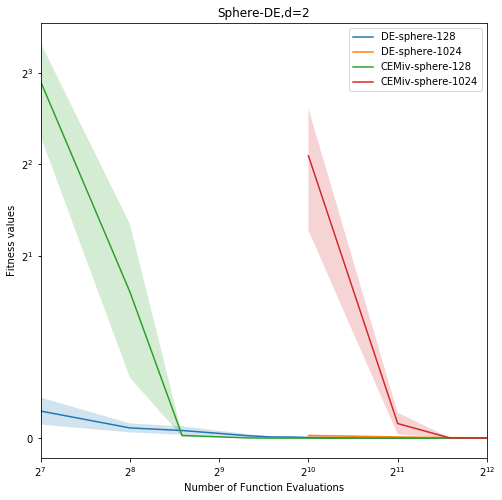

In [1859]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_xlim(128,2**12)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'Sphere-DE,d=2',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(sphere_count_de_128,sphere_fitness_de_128,label="DE-sphere-128")
ax.fill_between(sphere_count_de_128, lower_sphere_de_128, upper_sphere_de_128, alpha=0.2)

ax.plot(sphere_count_de_1024,sphere_fitness_de_1024,label="DE-sphere-1024")
ax.fill_between(sphere_count_de_1024, lower_sphere_de_1024, upper_sphere_de_1024, alpha=0.2)

ax.plot(sphere_count_CEMiv_128,sphere_fitness_CEMiv_128,label="CEMiv-sphere-128")
ax.fill_between(sphere_count_CEMiv_128, lower_sphere_CEMiv_128, upper_sphere_CEMiv_128, alpha=0.2)

ax.plot(sphere_count_CEMiv_1024,sphere_fitness_CEMiv_1024,label="CEMiv-sphere-1024")
ax.fill_between(sphere_count_CEMiv_1024, lower_sphere_CEMiv_1024, upper_sphere_CEMiv_1024, alpha=0.2)
#ax.plot(zakharov_count_de_128,zakharov_fitness_de_128,label="DE-zakharov-128")
#ax.fill_between(zakharov_count_de_128, lower_zakharov_de_128, upper_zakharov_de_128, alpha=0.2)

#ax.plot(rosenbrock_count_de_128,rosenbrock_fitness_de_128,label="DE-rosenbrock-128")
#ax.fill_between(rosenbrock_count_de_128, lower_rosenbrock_de_128, upper_rosenbrock_de_128, alpha=0.2)

#ax.plot(michalewicz_count_de_128,michalewicz_fitness_de_128,label="DE-michalewicz-128")
#ax.fill_between(michalewicz_count_de_128, lower_michalewicz_de_128, upper_michalewicz_de_128, alpha=0.2)

#ax.plot(ackley_count_de_128,ackley_fitness_de_128,label="DE-ackley-128")
#ax.fill_between(ackley_count_de_128, lower_ackley_de_128, upper_ackley_de_128, alpha=0.2)

#ax.plot(ackley_count_de_128, mean_de_128, label ="mean-DE-128")

ax.legend()
fig.savefig('Sphere-DE2.png')
fig.show()

**d = 10**

In [ ]:
lower_sphere_de_128_10, upper_sphere_de_128_10 = cal_error(sphere_fitness_de_128_10,sphere_std_de_128_10)
lower_sphere_de_1024_10, upper_sphere_de_1024_10 = cal_error(sphere_fitness_de_1024_10,sphere_std_de_1024_10)

lower_sphere_CEMiv_128_10, upper_sphere_CEMiv_128_10 = cal_error(sphere_fitness_CEMiv_128_10,sphere_std_CEMiv_128_10)
lower_sphere_CEMiv_1024_10, upper_sphere_CEMiv_1024_10 = cal_error(sphere_fitness_CEMiv_1024_10,sphere_std_CEMiv_1024_10)

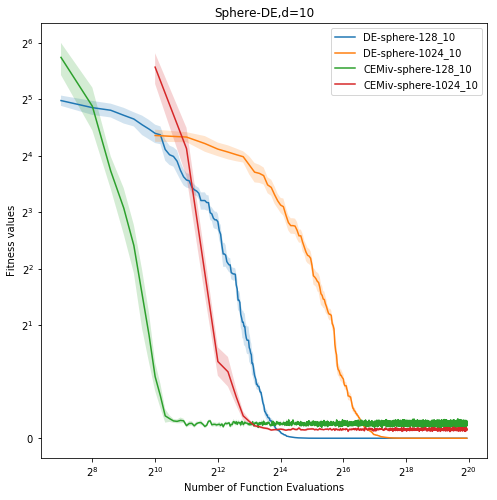

In [1863]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'Sphere-DE,d=10',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(sphere_count_de_128_10,sphere_fitness_de_128_10,label="DE-sphere-128_10")
ax.fill_between(sphere_count_de_128_10, lower_sphere_de_128_10, upper_sphere_de_128_10, alpha=0.2)

ax.plot(sphere_count_de_1024_10,sphere_fitness_de_1024_10,label="DE-sphere-1024_10")
ax.fill_between(sphere_count_de_1024_10, lower_sphere_de_1024_10, upper_sphere_de_1024_10, alpha=0.2)

ax.plot(sphere_count_CEMiv_128_10,sphere_fitness_CEMiv_128_10,label="CEMiv-sphere-128_10")
ax.fill_between(sphere_count_CEMiv_128_10, lower_sphere_CEMiv_128_10, upper_sphere_CEMiv_128_10, alpha=0.2)

ax.plot(sphere_count_CEMiv_1024_10,sphere_fitness_CEMiv_1024_10,label="CEMiv-sphere-1024_10")
ax.fill_between(sphere_count_CEMiv_1024_10, lower_sphere_CEMiv_1024_10, upper_sphere_CEMiv_1024_10, alpha=0.2)

ax.legend()
fig.savefig('Sphere-DE10.png')
fig.show()

## Zakharov Function

**d = 2**

In [ ]:
lower_zakharov_de_128, upper_zakharov_de_128 = cal_error(zakharov_fitness_de_128,zakharov_std_de_128)
lower_zakharov_de_1024, upper_zakharov_de_1024 = cal_error(zakharov_fitness_de_1024,zakharov_std_de_1024)

lower_zakharov_CEMiv_128, upper_zakharov_CEMiv_128 = cal_error(zakharov_fitness_CEMiv_128,zakharov_std_CEMiv_128)
lower_zakharov_CEMiv_1024, upper_zakharov_CEMiv_1024 = cal_error(zakharov_fitness_CEMiv_1024,zakharov_std_CEMiv_1024)

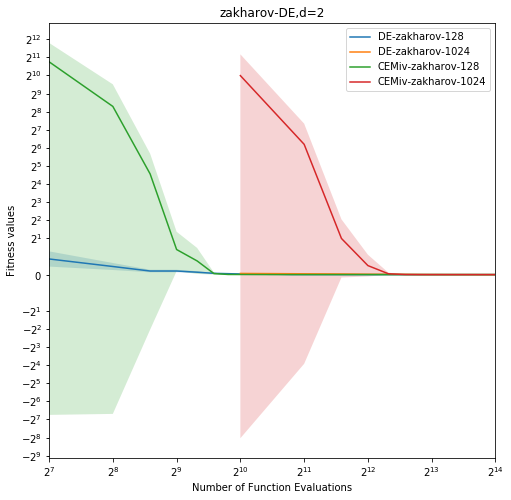

In [1894]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_xlim(128,2**14)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'zakharov-DE,d=2',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(zakharov_count_de_128,zakharov_fitness_de_128,label="DE-zakharov-128")
ax.fill_between(zakharov_count_de_128, lower_zakharov_de_128, upper_zakharov_de_128, alpha=0.2)

ax.plot(zakharov_count_de_1024,zakharov_fitness_de_1024,label="DE-zakharov-1024")
ax.fill_between(zakharov_count_de_1024, lower_zakharov_de_1024, upper_zakharov_de_1024, alpha=0.2)

ax.plot(zakharov_count_CEMiv_128,zakharov_fitness_CEMiv_128,label="CEMiv-zakharov-128")
ax.fill_between(zakharov_count_CEMiv_128, lower_zakharov_CEMiv_128, upper_zakharov_CEMiv_128, alpha=0.2)

ax.plot(zakharov_count_CEMiv_1024,zakharov_fitness_CEMiv_1024,label="CEMiv-zakharov-1024")
ax.fill_between(zakharov_count_CEMiv_1024, lower_zakharov_CEMiv_1024, upper_zakharov_CEMiv_1024, alpha=0.2)

ax.legend()
fig.savefig('zakharov-DE2.png')
fig.show()

**d = 10**

In [ ]:
lower_zakharov_de_128_10, upper_zakharov_de_128_10 = cal_error(zakharov_fitness_de_128_10,zakharov_std_de_128_10)
lower_zakharov_de_1024_10, upper_zakharov_de_1024_10 = cal_error(zakharov_fitness_de_1024_10,zakharov_std_de_1024_10)

lower_zakharov_CEMiv_128_10, upper_zakharov_CEMiv_128_10 = cal_error(zakharov_fitness_CEMiv_128_10,zakharov_std_CEMiv_128_10)
lower_zakharov_CEMiv_1024_10, upper_zakharov_CEMiv_1024_10 = cal_error(zakharov_fitness_CEMiv_1024_10,zakharov_std_CEMiv_1024_10)

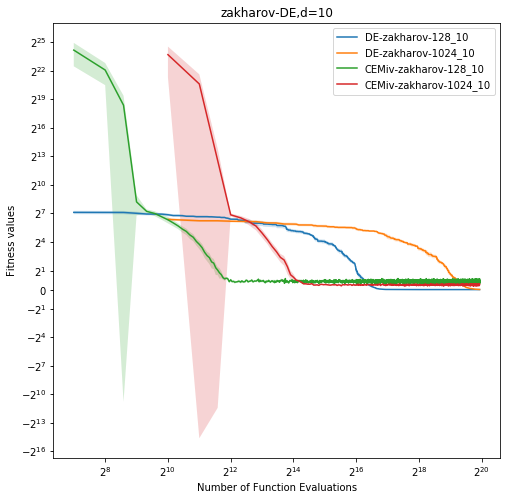

In [1875]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'zakharov-DE,d=10',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(zakharov_count_de_128_10,zakharov_fitness_de_128_10,label="DE-zakharov-128_10")
ax.fill_between(zakharov_count_de_128_10, lower_zakharov_de_128_10, upper_zakharov_de_128_10, alpha=0.2)

ax.plot(zakharov_count_de_1024_10,zakharov_fitness_de_1024_10,label="DE-zakharov-1024_10")
ax.fill_between(zakharov_count_de_1024_10, lower_zakharov_de_1024_10, upper_zakharov_de_1024_10, alpha=0.2)

ax.plot(zakharov_count_CEMiv_128_10,zakharov_fitness_CEMiv_128_10,label="CEMiv-zakharov-128_10")
ax.fill_between(zakharov_count_CEMiv_128_10, lower_zakharov_CEMiv_128_10, upper_zakharov_CEMiv_128_10, alpha=0.2)

ax.plot(zakharov_count_CEMiv_1024_10,zakharov_fitness_CEMiv_1024_10,label="CEMiv-zakharov-1024_10")
ax.fill_between(zakharov_count_CEMiv_1024_10, lower_zakharov_CEMiv_1024_10, upper_zakharov_CEMiv_1024_10, alpha=0.2)

ax.legend()
fig.savefig('zakharov-DE10.png')
fig.show()

## Rosenbrock Function

**d = 2**

In [77]:
lower_rosenbrock_de_128, upper_rosenbrock_de_128 = cal_error(rosenbrock_fitness_de_128,rosenbrock_std_de_128)
lower_rosenbrock_de_1024, upper_rosenbrock_de_1024 = cal_error(rosenbrock_fitness_de_1024,rosenbrock_std_de_1024)

lower_rosenbrock_CEMiv_128, upper_rosenbrock_CEMiv_128 = cal_error(rosenbrock_fitness_CEMiv_128,rosenbrock_std_CEMiv_128)
lower_rosenbrock_CEMiv_1024, upper_rosenbrock_CEMiv_1024 = cal_error(rosenbrock_fitness_CEMiv_1024,rosenbrock_std_CEMiv_1024)

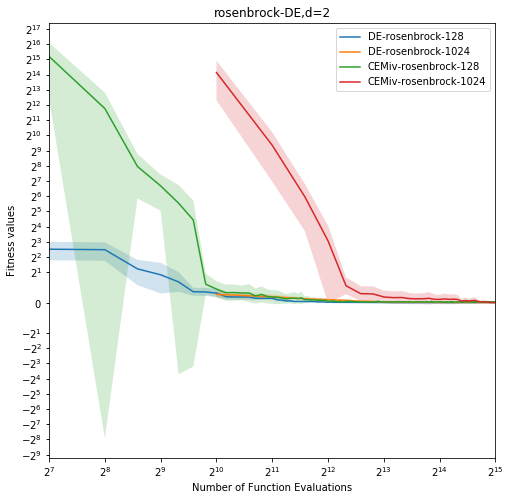

In [78]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_xlim(128,2**15)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'rosenbrock-DE,d=2',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(rosenbrock_count_de_128,rosenbrock_fitness_de_128,label="DE-rosenbrock-128")
ax.fill_between(rosenbrock_count_de_128, lower_rosenbrock_de_128, upper_rosenbrock_de_128, alpha=0.2)

ax.plot(rosenbrock_count_de_1024,rosenbrock_fitness_de_1024,label="DE-rosenbrock-1024")
ax.fill_between(rosenbrock_count_de_1024, lower_rosenbrock_de_1024, upper_rosenbrock_de_1024, alpha=0.2)

ax.plot(rosenbrock_count_CEMiv_128,rosenbrock_fitness_CEMiv_128,label="CEMiv-rosenbrock-128")
ax.fill_between(rosenbrock_count_CEMiv_128, lower_rosenbrock_CEMiv_128, upper_rosenbrock_CEMiv_128, alpha=0.2)

ax.plot(rosenbrock_count_CEMiv_1024,rosenbrock_fitness_CEMiv_1024,label="CEMiv-rosenbrock-1024")
ax.fill_between(rosenbrock_count_CEMiv_1024, lower_rosenbrock_CEMiv_1024, upper_rosenbrock_CEMiv_1024, alpha=0.2)

ax.legend()
fig.savefig('rosenbrock-DE2.png')
fig.show()

**d = 10**

In [ ]:
lower_rosenbrock_de_128_10, upper_rosenbrock_de_128_10 = cal_error(rosenbrock_fitness_de_128_10,rosenbrock_std_de_128_10)
lower_rosenbrock_de_1024_10, upper_rosenbrock_de_1024_10 = cal_error(rosenbrock_fitness_de_1024_10,rosenbrock_std_de_1024_10)

lower_rosenbrock_CEMiv_128_10, upper_rosenbrock_CEMiv_128_10 = cal_error(rosenbrock_fitness_CEMiv_128_10,rosenbrock_std_CEMiv_128_10)
lower_rosenbrock_CEMiv_1024_10, upper_rosenbrock_CEMiv_1024_10 = cal_error(rosenbrock_fitness_CEMiv_1024_10,rosenbrock_std_CEMiv_1024_10)

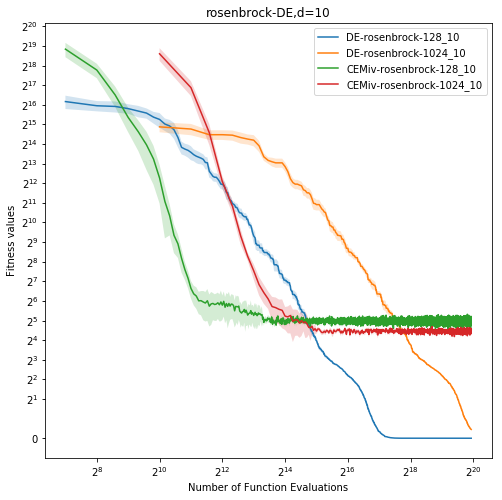

In [1881]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
ax.set_yscale('symlog',basey=2)
ax.set( title = 'rosenbrock-DE,d=10',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(rosenbrock_count_de_128_10,rosenbrock_fitness_de_128_10,label="DE-rosenbrock-128_10")
ax.fill_between(rosenbrock_count_de_128_10, lower_rosenbrock_de_128_10, upper_rosenbrock_de_128_10, alpha=0.2)

ax.plot(rosenbrock_count_de_1024_10,rosenbrock_fitness_de_1024_10,label="DE-rosenbrock-1024_10")
ax.fill_between(rosenbrock_count_de_1024_10, lower_rosenbrock_de_1024_10, upper_rosenbrock_de_1024_10, alpha=0.2)

ax.plot(rosenbrock_count_CEMiv_128_10,rosenbrock_fitness_CEMiv_128_10,label="CEMiv-rosenbrock-128_10")
ax.fill_between(rosenbrock_count_CEMiv_128_10, lower_rosenbrock_CEMiv_128_10, upper_rosenbrock_CEMiv_128_10, alpha=0.2)

ax.plot(rosenbrock_count_CEMiv_1024_10,rosenbrock_fitness_CEMiv_1024_10,label="CEMiv-rosenbrock-1024_10")
ax.fill_between(rosenbrock_count_CEMiv_1024_10, lower_rosenbrock_CEMiv_1024_10, upper_rosenbrock_CEMiv_1024_10, alpha=0.2)

ax.legend()
fig.savefig('rosenbrock-DE10.png')
fig.show()

## Michalewicz Function

**d = 2**

In [83]:
lower_michalewicz_de_128, upper_michalewicz_de_128 = cal_error(michalewicz_fitness_de_128,michalewicz_std_de_128)
lower_michalewicz_de_1024, upper_michalewicz_de_1024 = cal_error(michalewicz_fitness_de_1024,michalewicz_std_de_1024)

lower_michalewicz_CEMiv_128, upper_michalewicz_CEMiv_128 = cal_error(michalewicz_fitness_CEMiv_128,michalewicz_std_CEMiv_128)
lower_michalewicz_CEMiv_1024, upper_michalewicz_CEMiv_1024 = cal_error(michalewicz_fitness_CEMiv_1024,michalewicz_std_CEMiv_1024)

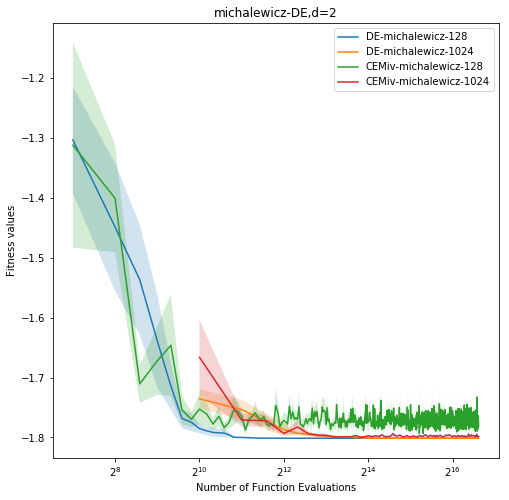

In [84]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
#ax.set_yscale('symlog',basey=2)
ax.set( title = 'michalewicz-DE,d=2',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(michalewicz_count_de_128,michalewicz_fitness_de_128,label="DE-michalewicz-128")
ax.fill_between(michalewicz_count_de_128, lower_michalewicz_de_128, upper_michalewicz_de_128, alpha=0.2)

ax.plot(michalewicz_count_de_1024,michalewicz_fitness_de_1024,label="DE-michalewicz-1024")
ax.fill_between(michalewicz_count_de_1024, lower_michalewicz_de_1024, upper_michalewicz_de_1024, alpha=0.2)

ax.plot(michalewicz_count_CEMiv_128,michalewicz_fitness_CEMiv_128,label="CEMiv-michalewicz-128")
ax.fill_between(michalewicz_count_CEMiv_128, lower_michalewicz_CEMiv_128, upper_michalewicz_CEMiv_128, alpha=0.2)

ax.plot(michalewicz_count_CEMiv_1024,michalewicz_fitness_CEMiv_1024,label="CEMiv-michalewicz-1024")
ax.fill_between(michalewicz_count_CEMiv_1024, lower_michalewicz_CEMiv_1024, upper_michalewicz_CEMiv_1024, alpha=0.2)

ax.legend()
fig.savefig('michalewicz-DE2.png')
fig.show()

**d = 10**

In [ ]:
lower_michalewicz_de_128_10, upper_michalewicz_de_128_10 = cal_error(michalewicz_fitness_de_128_10,michalewicz_std_de_128_10)
lower_michalewicz_de_1024_10, upper_michalewicz_de_1024_10 = cal_error(michalewicz_fitness_de_1024_10,michalewicz_std_de_1024_10)

lower_michalewicz_CEMiv_128_10, upper_michalewicz_CEMiv_128_10 = cal_error(michalewicz_fitness_CEMiv_128_10,michalewicz_std_CEMiv_128_10)
lower_michalewicz_CEMiv_1024_10, upper_michalewicz_CEMiv_1024_10 = cal_error(michalewicz_fitness_CEMiv_1024_10,michalewicz_std_CEMiv_1024_10)

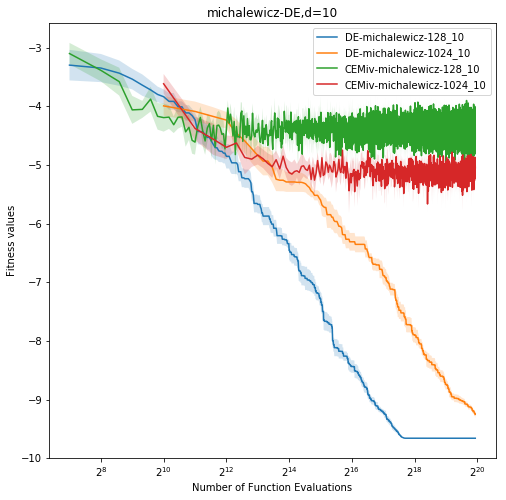

In [1885]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
#ax.set_yscale('symlog',basey=2)
ax.set( title = 'michalewicz-DE,d=10',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(michalewicz_count_de_128_10,michalewicz_fitness_de_128_10,label="DE-michalewicz-128_10")
ax.fill_between(michalewicz_count_de_128_10, lower_michalewicz_de_128_10, upper_michalewicz_de_128_10, alpha=0.2)

ax.plot(michalewicz_count_de_1024_10,michalewicz_fitness_de_1024_10,label="DE-michalewicz-1024_10")
ax.fill_between(michalewicz_count_de_1024_10, lower_michalewicz_de_1024_10, upper_michalewicz_de_1024_10, alpha=0.2)

ax.plot(michalewicz_count_CEMiv_128_10,michalewicz_fitness_CEMiv_128_10,label="CEMiv-michalewicz-128_10")
ax.fill_between(michalewicz_count_CEMiv_128_10, lower_michalewicz_CEMiv_128_10, upper_michalewicz_CEMiv_128_10, alpha=0.2)

ax.plot(michalewicz_count_CEMiv_1024_10,michalewicz_fitness_CEMiv_1024_10,label="CEMiv-michalewicz-1024_10")
ax.fill_between(michalewicz_count_CEMiv_1024_10, lower_michalewicz_CEMiv_1024_10, upper_michalewicz_CEMiv_1024_10, alpha=0.2)

ax.legend()
fig.savefig('michalewicz-DE10.png')
fig.show()

## Ackley Function

**d = 2**

In [ ]:
lower_ackley_de_128, upper_ackley_de_128 = cal_error(ackley_fitness_de_128,ackley_std_de_128)
lower_ackley_de_1024, upper_ackley_de_1024 = cal_error(ackley_fitness_de_1024,ackley_std_de_1024)

lower_ackley_CEMiv_128, upper_ackley_CEMiv_128 = cal_error(ackley_fitness_CEMiv_128,ackley_std_CEMiv_128)
lower_ackley_CEMiv_1024, upper_ackley_CEMiv_1024 = cal_error(ackley_fitness_CEMiv_1024,ackley_std_CEMiv_1024)

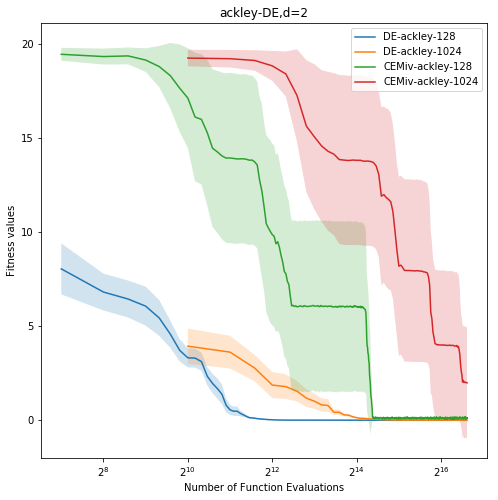

In [1892]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
#ax.set_xlim(128,2**12)
#ax.set_yscale('symlog',basey=2)
ax.set( title = 'ackley-DE,d=2',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(ackley_count_de_128,ackley_fitness_de_128,label="DE-ackley-128")
ax.fill_between(ackley_count_de_128, lower_ackley_de_128, upper_ackley_de_128, alpha=0.2)

ax.plot(ackley_count_de_1024,ackley_fitness_de_1024,label="DE-ackley-1024")
ax.fill_between(ackley_count_de_1024, lower_ackley_de_1024, upper_ackley_de_1024, alpha=0.2)

ax.plot(ackley_count_CEMiv_128,ackley_fitness_CEMiv_128,label="CEMiv-ackley-128")
ax.fill_between(ackley_count_CEMiv_128, lower_ackley_CEMiv_128, upper_ackley_CEMiv_128, alpha=0.2)

ax.plot(ackley_count_CEMiv_1024,ackley_fitness_CEMiv_1024,label="CEMiv-ackley-1024")
ax.fill_between(ackley_count_CEMiv_1024, lower_ackley_CEMiv_1024, upper_ackley_CEMiv_1024, alpha=0.2)

ax.legend()
fig.savefig('ackley-DE2.png')
fig.show()

**d = 10**

In [ ]:
lower_ackley_de_128_10, upper_ackley_de_128_10 = cal_error(ackley_fitness_de_128_10,ackley_std_de_128_10)
lower_ackley_de_1024_10, upper_ackley_de_1024_10 = cal_error(ackley_fitness_de_1024_10,ackley_std_de_1024_10)

lower_ackley_CEMiv_128_10, upper_ackley_CEMiv_128_10 = cal_error(ackley_fitness_CEMiv_128_10,ackley_std_CEMiv_128_10)
lower_ackley_CEMiv_1024_10, upper_ackley_CEMiv_1024_10 = cal_error(ackley_fitness_CEMiv_1024_10,ackley_std_CEMiv_1024_10)

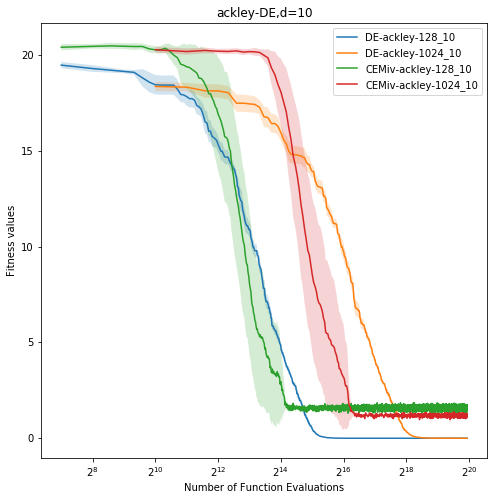

In [1891]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xscale('log',basex=2)
#ax.set_yscale('symlog',basey=2)
ax.set( title = 'ackley-DE,d=10',
        xlabel= 'Number of Function Evaluations',
        ylabel= 'Fitness values')
#
ax.plot(ackley_count_de_128_10,ackley_fitness_de_128_10,label="DE-ackley-128_10")
ax.fill_between(ackley_count_de_128_10, lower_ackley_de_128_10, upper_ackley_de_128_10, alpha=0.2)

ax.plot(ackley_count_de_1024_10,ackley_fitness_de_1024_10,label="DE-ackley-1024_10")
ax.fill_between(ackley_count_de_1024_10, lower_ackley_de_1024_10, upper_ackley_de_1024_10, alpha=0.2)

ax.plot(ackley_count_CEMiv_128_10,ackley_fitness_CEMiv_128_10,label="CEMiv-ackley-128_10")
ax.fill_between(ackley_count_CEMiv_128_10, lower_ackley_CEMiv_128_10, upper_ackley_CEMiv_128_10, alpha=0.2)

ax.plot(ackley_count_CEMiv_1024_10,ackley_fitness_CEMiv_1024_10,label="CEMiv-ackley-1024_10")
ax.fill_between(ackley_count_CEMiv_1024_10, lower_ackley_CEMiv_1024_10, upper_ackley_CEMiv_1024_10, alpha=0.2)

ax.legend()
fig.savefig('ackley-DE10.png')
fig.show()

# TABLE

In [85]:
def table_DE(fobj, bounds, popsize, max_evals=1e5, seed_number = 20521482):
    fitness = []
    
    for i in range(10):
        results, all_pops, generation_count = de(fobj=fobj, bounds=bounds, popsize=popsize, max_evals=max_evals, seed_number = seed_number + i)
        results = np.array(results,dtype=object)
        fitness.append(results[-1,1])
        
    return np.mean(fitness), np.std(fitness)

In [86]:
def table_CEMiv(fobj, bounds, popsize, max_evals=1e5, seed_number = 20521482):
    all_fitness = []
    
    for i in range(10):
        results, fitness, all_pops, count_list, generation_count = CEMiv(fobj=fobj, bounds=bounds, popsize = popsize, num_elite = popsize//2, sigma_init = 1, extra_std = 0.06, seed_number = seed + i, max_evals = max_evals)
        all_fitness.append(fitness[-1])
    
    return np.mean(all_fitness), np.std(all_fitness)

In [10]:
def transform(tab, list_std):
    tab = tab.astype(str) + "(" + list_std.astype(str) + ")"
    return tab

## Sphere Function

**d = 2**

In [90]:
de_fitness_sphere2 = []
de_std_sphere2 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(SphereFunction, bounds=bounds_dict["Sphere"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    de_fitness_sphere2.append(mean_fitness)
    de_std_sphere2.append(std_fitness)

In [87]:
cem_fitness_sphere2 = []
cem_std_sphere2 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(SphereFunction, bounds=bounds_dict["Sphere"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    cem_fitness_sphere2.append(mean_fitness)
    cem_std_sphere2.append(std_fitness)     

In [91]:
piv_de_sphere_2 = {"Popsize N/λ": N,"DE-Sphere,d=2": np.round(de_fitness_sphere2,5), "CEM-Sphere,d=2": np.round(cem_fitness_sphere2,5)}
tab = pd.DataFrame(data=piv_de_sphere_2,index=None)
tab["DE-Sphere,d=2"] = transform(tab["DE-Sphere,d=2"], np.round(de_std_sphere2,5))
tab["CEM-Sphere,d=2"] = transform(tab["CEM-Sphere,d=2"], np.round(cem_std_sphere2,5))

table_de_sphere_2 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_sphere_2

,"CEM-Sphere,d=2","DE-Sphere,d=2"
Popsize N/λ,,
32,0.00597(0.00385),0.0(0.0)
64,0.00222(0.00253),0.0(0.0)
128,0.00087(0.00084),0.0(0.0)
256,0.00024(0.00022),0.0(0.0)
512,7e-05(6e-05),0.0(0.0)
1024,7e-05(8e-05),0.0(0.0)


**d = 10**

In [104]:
de_fitness_sphere10 = []
de_std_sphere10 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(SphereFunction, bounds=bounds_dict["Sphere"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    de_fitness_sphere10.append(mean_fitness)
    de_std_sphere10.append(std_fitness)

In [105]:
cem_fitness_sphere10 = []
cem_std_sphere10 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(SphereFunction, bounds=bounds_dict["Sphere"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    cem_fitness_sphere10.append(mean_fitness)
    cem_std_sphere10.append(std_fitness) 

In [106]:
piv_de_sphere_10 = {"Popsize N/λ": N,"DE-Sphere,d=10": np.round(de_fitness_sphere10,5), "CEM-Sphere,d=10": np.round(cem_fitness_sphere10,5)}
tab = pd.DataFrame(data=piv_de_sphere_10,index=None)
tab["DE-Sphere,d=10"] = transform(tab["DE-Sphere,d=10"], np.round(de_std_sphere10,5))
tab["CEM-Sphere,d=10"] = transform(tab["CEM-Sphere,d=10"], np.round(cem_std_sphere10,5))

table_de_sphere_10 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_sphere_10

,"CEM-Sphere,d=10","DE-Sphere,d=10"
Popsize N/λ,,
32,0.42347(0.15829),0.0(0.0)
64,0.29951(0.05964),0.0(0.0)
128,0.27626(0.03368),0.0(0.0)
256,0.23536(0.05872),0.0(0.0)
512,0.18536(0.02902),0.0(0.0)
1024,0.14883(0.0422),0.0(0.0)


## Zakharov Function

**d = 2**

In [92]:
de_fitness_zakharov2 = []
de_std_zakharov2 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(ZakharovFunction, bounds=bounds_dict["Zakharov"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    de_fitness_zakharov2.append(mean_fitness)
    de_std_zakharov2.append(std_fitness)

In [93]:
cem_fitness_zakharov2 = []
cem_std_zakharov2 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(ZakharovFunction, bounds=bounds_dict["Zakharov"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    cem_fitness_zakharov2.append(mean_fitness)
    cem_std_zakharov2.append(std_fitness)

In [118]:
piv_de_zakharov_2 = {"Popsize N/λ": N,"DE-zakharov,d=2": np.round(de_fitness_zakharov2,5), "CEM-zakharov,d=2": np.round(cem_fitness_zakharov2,5)}
tab = pd.DataFrame(data=piv_de_zakharov_2,index=None)
tab["DE-zakharov,d=2"] = transform(tab["DE-zakharov,d=2"], np.round(de_std_zakharov2,5))
tab["CEM-zakharov,d=2"] = transform(tab["CEM-zakharov,d=2"], np.round(cem_std_zakharov2,5))

table_de_zakharov_2 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_zakharov_2

,"CEM-zakharov,d=2","DE-zakharov,d=2"
Popsize N/λ,,
32,0.0065(0.00711),0.0(0.0)
64,0.00336(0.00322),0.0(0.0)
128,0.00119(0.00115),0.0(0.0)
256,0.00036(0.00031),0.0(0.0)
512,0.00013(0.00012),0.0(0.0)
1024,0.0001(0.0001),0.0(0.0)


**d = 10**

In [123]:
de_fitness_zakharov10 = []
de_std_zakharov10 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(ZakharovFunction, bounds=bounds_dict["Zakharov"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    de_fitness_zakharov10.append(mean_fitness)
    de_std_zakharov10.append(std_fitness)

In [124]:
cem_fitness_zakharov10 = []
cem_std_zakharov10 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(ZakharovFunction, bounds=bounds_dict["Zakharov"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    cem_fitness_zakharov10.append(mean_fitness)
    cem_std_zakharov10.append(std_fitness) 

In [141]:
piv_de_zakharov_10 = {"Popsize N/λ": N,"DE-zakharov,d=10": np.round(de_fitness_zakharov10,5), "CEM-zakharov,d=10": np.round(cem_fitness_zakharov10,5)}
tab = pd.DataFrame(data=piv_de_zakharov_10,index=None)
tab["DE-zakharov,d=10"] = transform(tab["DE-zakharov,d=10"], np.round(de_std_zakharov10,5))
tab["CEM-zakharov,d=10"] = transform(tab["CEM-zakharov,d=10"], np.round(cem_std_zakharov10,5))

table_de_zakharov_10 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_zakharov_10

,"CEM-zakharov,d=10","DE-zakharov,d=10"
Popsize N/λ,,
32,1.69332(0.61684),0.0(0.0)
64,1.21712(0.43901),0.0(0.0)
128,0.97004(0.31074),0.0(0.0)
256,0.72192(0.18176),0.0(0.0)
512,0.73489(0.1),0.0(0.0)
1024,0.56194(0.10487),0.01354(0.00398)


## Rosenbrock Function

**d = 2**

In [95]:
de_fitness_Rosenbrock2 = []
de_std_Rosenbrock2 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    de_fitness_Rosenbrock2.append(mean_fitness)
    de_std_Rosenbrock2.append(std_fitness)

In [96]:
cem_fitness_Rosenbrock2 = []
cem_std_Rosenbrock2 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    cem_fitness_Rosenbrock2.append(mean_fitness)
    cem_std_Rosenbrock2.append(std_fitness) 
    

In [97]:
piv_de_Rosenbrock_2 = {"Popsize N/λ": N,"DE-Rosenbrock,d=2": np.round(de_fitness_Rosenbrock2,5), "CEM-Rosenbrock,d=2": np.round(cem_fitness_Rosenbrock2,5)}
tab = pd.DataFrame(data=piv_de_Rosenbrock_2,index=None)
tab["DE-Rosenbrock,d=2"] = transform(tab["DE-Rosenbrock,d=2"], np.round(de_std_Rosenbrock2,5))
tab["CEM-Rosenbrock,d=2"] = transform(tab["CEM-Rosenbrock,d=2"], np.round(cem_std_Rosenbrock2,5))

table_de_Rosenbrock_2 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Rosenbrock_2

,"CEM-Rosenbrock,d=2","DE-Rosenbrock,d=2"
Popsize N/λ,,
32,0.17155(0.17989),0.0(0.0)
64,0.06007(0.04044),0.0(0.0)
128,0.04459(0.03894),0.0(0.0)
256,0.02118(0.01222),0.0(0.0)
512,0.00546(0.00625),0.0(0.0)
1024,0.00421(0.00171),0.0(0.0)


**d = 10**

In [126]:
de_fitness_Rosenbrock10 = []
de_std_Rosenbrock10 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    de_fitness_Rosenbrock10.append(mean_fitness)
    de_std_Rosenbrock10.append(std_fitness)

In [127]:
cem_fitness_Rosenbrock10 = []
cem_std_Rosenbrock10 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(RosenbrockFunction, bounds=bounds_dict["Rosenbrock"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    cem_fitness_Rosenbrock10.append(mean_fitness)
    cem_std_Rosenbrock10.append(std_fitness) 

In [128]:
piv_de_Rosenbrock_10 = {"Popsize N/λ": N,"DE-Rosenbrock,d=10": np.round(de_fitness_Rosenbrock10,5), "CEM-Rosenbrock,d=10": np.round(cem_fitness_Rosenbrock10,5)}
tab = pd.DataFrame(data=piv_de_Rosenbrock_10,index=None)
tab["DE-Rosenbrock,d=10"] = transform(tab["DE-Rosenbrock,d=10"], np.round(de_std_Rosenbrock10,5))
tab["CEM-Rosenbrock,d=10"] = transform(tab["CEM-Rosenbrock,d=10"], np.round(cem_std_Rosenbrock10,5))

table_de_Rosenbrock_10 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Rosenbrock_10

,"CEM-Rosenbrock,d=10","DE-Rosenbrock,d=10"
Popsize N/λ,,
32,45.02323(17.95926),0.0(0.0)
64,39.15314(6.86243),0.0(0.0)
128,32.67031(7.43),0.0(0.0)
256,27.28374(4.61569),0.0(0.0)
512,22.36266(4.48565),0.0002(5e-05)
1024,23.39741(2.86128),0.44992(0.03827)


## Michalewicz Function

**d = 2**

In [98]:
de_fitness_Michalewicz2 = []
de_std_Michalewicz2 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    de_fitness_Michalewicz2.append(mean_fitness)
    de_std_Michalewicz2.append(std_fitness)

In [99]:
cem_fitness_Michalewicz2 = []
cem_std_Michalewicz2 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    cem_fitness_Michalewicz2.append(mean_fitness)
    cem_std_Michalewicz2.append(std_fitness) 

In [100]:
piv_de_Michalewicz_2 = {"Popsize N/λ": N,"DE-Michalewicz,d=2": np.round(de_fitness_Michalewicz2,5), "CEM-Michalewicz,d=2": np.round(cem_fitness_Michalewicz2,5)}
tab = pd.DataFrame(data=piv_de_Michalewicz_2,index=None)
tab["DE-Michalewicz,d=2"] = transform(tab["DE-Michalewicz,d=2"], np.round(de_std_Michalewicz2,5))
tab["CEM-Michalewicz,d=2"] = transform(tab["CEM-Michalewicz,d=2"], np.round(cem_std_Michalewicz2,5))

table_de_Michalewicz_2 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Michalewicz_2

,"CEM-Michalewicz,d=2","DE-Michalewicz,d=2"
Popsize N/λ,,
32,-1.69593(0.09596),-1.8013(0.0)
64,-1.74183(0.05839),-1.8013(0.0)
128,-1.78069(0.01858),-1.8013(0.0)
256,-1.7901(0.00855),-1.8013(0.0)
512,-1.79709(0.00307),-1.8013(0.0)
1024,-1.79875(0.00355),-1.8013(0.0)


**d = 10**

In [129]:
de_fitness_Michalewicz10 = []
de_std_Michalewicz10 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    de_fitness_Michalewicz10.append(mean_fitness)
    de_std_Michalewicz10.append(std_fitness)

In [130]:
cem_fitness_Michalewicz10 = []
cem_std_Michalewicz10 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(MichalewiczFunction, bounds=bounds_dict["Michalewicz"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    cem_fitness_Michalewicz10.append(mean_fitness)
    cem_std_Michalewicz10.append(std_fitness) 

In [131]:
piv_de_Michalewicz_10 = {"Popsize N/λ": N,"DE-Michalewicz,d=10": np.round(de_fitness_Michalewicz10,5), "CEM-Michalewicz,d=10": np.round(cem_fitness_Michalewicz10,5)}
tab = pd.DataFrame(data=piv_de_Michalewicz_10,index=None)
tab["DE-Michalewicz,d=10"] = transform(tab["DE-Michalewicz,d=10"], np.round(de_std_Michalewicz10,5))
tab["CEM-Michalewicz,d=10"] = transform(tab["CEM-Michalewicz,d=10"], np.round(cem_std_Michalewicz10,5))

table_de_Michalewicz_10 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Michalewicz_10

,"CEM-Michalewicz,d=10","DE-Michalewicz,d=10"
Popsize N/λ,,
32,-3.68037(0.43684),-9.63772(0.02068)
64,-4.01524(0.32531),-9.66015(0.0)
128,-4.55537(0.3667),-9.66015(0.0)
256,-4.84328(0.62876),-9.66015(0.0)
512,-4.99113(0.35068),-9.66015(0.0)
1024,-5.04704(0.31658),-9.25392(0.11207)


## Ackley Function

**d = 2**

In [101]:
de_fitness_Ackley2 = []
de_std_Ackley2 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(AckleyFunction, bounds=bounds_dict["Ackley"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    de_fitness_Ackley2.append(mean_fitness)
    de_std_Ackley2.append(std_fitness)

In [102]:
cem_fitness_Ackley2 = []
cem_std_Ackley2 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(AckleyFunction, bounds=bounds_dict["Ackley"]*2, popsize=n, max_evals=1e5, seed_number = seed)
    cem_fitness_Ackley2.append(mean_fitness)
    cem_std_Ackley2.append(std_fitness) 

In [103]:
piv_de_Ackley_2 = {"Popsize N/λ": N,"DE-Ackley,d=2": np.round(de_fitness_Ackley2,5), "CEM-Ackley,d=2": np.round(cem_fitness_Ackley2,5)}
tab = pd.DataFrame(data=piv_de_Ackley_2,index=None)
tab["DE-Ackley,d=2"] = transform(tab["DE-Ackley,d=2"], np.round(de_std_Ackley2,5))
tab["CEM-Ackley,d=2"] = transform(tab["CEM-Ackley,d=2"], np.round(cem_std_Ackley2,5))

table_de_Ackley_2 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Ackley_2

,"CEM-Ackley,d=2","DE-Ackley,d=2"
Popsize N/λ,,
32,0.37828(0.15764),0.0(0.0)
64,0.19671(0.15137),0.0(0.0)
128,0.11609(0.08892),0.0(0.0)
256,0.03624(0.02538),0.0(0.0)
512,0.01749(0.00596),0.0(0.0)
1024,1.98203(5.87023),0.0(0.0)


**d = 10**

In [132]:
de_fitness_Ackley10 = []
de_std_Ackley10 = [] 

for n in N:
    mean_fitness, std_fitness = table_DE(AckleyFunction, bounds=bounds_dict["Ackley"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    de_fitness_Ackley10.append(mean_fitness)
    de_std_Ackley10.append(std_fitness)

In [133]:
cem_fitness_Ackley10 = []
cem_std_Ackley10 = [] 

for n in N:
    mean_fitness,std_fitness = table_CEMiv(AckleyFunction, bounds=bounds_dict["Ackley"]*10, popsize=n, max_evals=1e6, seed_number = seed)
    cem_fitness_Ackley10.append(mean_fitness)
    cem_std_Ackley10.append(std_fitness) 

In [134]:
piv_de_Ackley_10 = {"Popsize N/λ": N,"DE-Ackley,d=10": np.round(de_fitness_Ackley10,5), "CEM-Ackley,d=10": np.round(cem_fitness_Ackley10,5)}
tab = pd.DataFrame(data=piv_de_Ackley_10,index=None)
tab["DE-Ackley,d=10"] = transform(tab["DE-Ackley,d=10"], np.round(de_std_Ackley10,5))
tab["CEM-Ackley,d=10"] = transform(tab["CEM-Ackley,d=10"], np.round(cem_std_Ackley10,5))

table_de_Ackley_10 = pd.pivot_table(tab, index="Popsize N/λ",aggfunc=lambda x: ' '.join(x))
table_de_Ackley_10

,"CEM-Ackley,d=10","DE-Ackley,d=10"
Popsize N/λ,,
32,2.09254(0.12911),0.0(0.0)
64,1.61766(0.31065),0.0(0.0)
128,1.60912(0.13924),0.0(0.0)
256,1.57104(0.2261),0.0(0.0)
512,1.31162(0.20394),0.0(0.0)
1024,1.18873(0.2019),0.0(0.0)


## Calculate t_test and p_value

In [31]:
def cal_tp(mean_1,mean_2,std_1,std_2):
    mean_1 = np.array(mean_1)
    mean_2 = np.array(mean_2)
    std_1 = np.array(std_1)
    std_2 = np.array(std_2)
    t_test, p_value = ttest_ind_from_stats( mean1=mean_1, std1=std_1, nobs1=len(mean_1),
                                            mean2=mean_2, std2=std_2, nobs2=len(mean_2))
    
    print("t-test:", t_test)
    print("p-value:", p_value)
    return t_test, p_value

## Sphere Function

**d = 2**

In [107]:
ttest_sphere2, pvalue_sphere2 = cal_tp(de_fitness_sphere2,cem_fitness_sphere2,de_std_sphere2,cem_std_sphere2)

t-test: [-3.79454432 -2.14737071 -2.53948654 -2.63339078 -2.95393101 -2.28764183]
p-value: [0.0035171  0.05731812 0.02938901 0.02501614 0.01443723 0.0451946 ]


**d = 10**

In [108]:
ttest_sphere10, pvalue_sphere10 = cal_tp(de_fitness_sphere10,cem_fitness_sphere10,de_std_sphere10,cem_std_sphere10)

t-test: [ -6.55313161 -12.30178975 -20.09365727  -9.81803142 -15.64820068
  -8.63936474]
p-value: [6.44737718e-05 2.31206813e-07 2.05023711e-09 1.88046186e-06
 2.32682378e-08 5.96786718e-06]


## Zakharov Function

**d = 2**

In [109]:
ttest_zakharov2, pvalue_zakharov2 = cal_tp(de_fitness_zakharov2,cem_fitness_zakharov2,de_std_zakharov2,cem_std_zakharov2)

t-test: [-2.24053652 -2.55338973 -2.54119962 -2.84798033 -2.64272611 -2.38171671]
p-value: [0.04895965 0.02869666 0.02930282 0.01730992 0.02461851 0.03849939]


**d = 10**

In [135]:
ttest_zakharov10, pvalue_zakharov10 = cal_tp(de_fitness_zakharov10,cem_fitness_zakharov10,de_std_zakharov10,cem_std_zakharov10)

t-test: [ -6.72419721  -6.79096351  -7.64653486  -9.7286816  -18.00076121
 -12.80043496]
p-value: [5.20585565e-05 4.79364957e-05 1.74535223e-05 2.04416202e-06
 5.99348260e-09 1.58814825e-07]


## Rosenbrock Function

**d = 2**

In [110]:
ttest_rosenbrock2, pvalue_rosenbrock2 = cal_tp(de_fitness_Rosenbrock2,cem_fitness_Rosenbrock2,de_std_Rosenbrock2,cem_std_Rosenbrock2)

t-test: [-2.33591071 -3.63849595 -2.80541592 -4.24534931 -2.1395084  -6.02126576]
p-value: [0.04162874 0.0045481  0.01862074 0.00170197 0.05808309 0.00012842]


**d = 10**

In [136]:
ttest_rosenbrock10, pvalue_rosenbrock10 = cal_tp(de_fitness_Rosenbrock10,cem_fitness_Rosenbrock10,de_std_Rosenbrock10,cem_std_Rosenbrock10)

t-test: [ -6.14078457 -13.97539548 -10.77060585 -14.47914996 -12.21152955
 -19.64319783]
p-value: [1.09641774e-04 6.88712822e-08 8.01726433e-07 4.90786165e-08
 2.47828805e-07 2.55882692e-09]


## Michalewicz Function

**d = 2**

In [111]:
ttest_michalewicz2, pvalue_michalewicz2 = cal_tp(de_fitness_Michalewicz2,cem_fitness_Michalewicz2,de_std_Michalewicz2,cem_std_Michalewicz2)

t-test: [-2.68980666 -2.49496253 -2.71845546 -3.2074407  -3.36860313 -1.76099705]
p-value: [0.02270723 0.03171941 0.02161756 0.00937264 0.00713819 0.10872789]


**d = 10**

In [137]:
ttest_michalewicz10, pvalue_michalewicz10 = cal_tp(de_fitness_Michalewicz10,cem_fitness_Michalewicz10,de_std_Michalewicz10,cem_std_Michalewicz10)

t-test: [-33.36754468 -42.50455504 -34.09894602 -18.76516473 -32.6126347
 -30.68395645]
p-value: [1.38057183e-11 1.24668882e-12 1.11338186e-11 3.99785979e-09
 1.73225946e-11 3.16924138e-11]


## Ackley Function

**d = 2**

In [112]:
ttest_ackley2, pvalue_ackley2 = cal_tp(de_fitness_Ackley2,cem_fitness_Ackley2,de_std_Ackley2,cem_std_Ackley2)

t-test: [-5.87778226 -3.18329653 -3.19809928 -3.4969737  -7.18828003 -0.82704686]
p-value: [1.55651435e-04 9.76463936e-03 9.52235634e-03 5.75553462e-03
 2.96699445e-05 4.27504487e-01]


**d = 10**

In [138]:
ttest_ackley10, pvalue_ackley10 = cal_tp(de_fitness_Ackley10,cem_fitness_Ackley10,de_std_Ackley10,cem_std_Ackley10)

t-test: [-39.69895175 -12.75523924 -28.3074821  -17.02012261 -15.75324304
 -14.42189619]
p-value: [2.45877898e-12 1.64224892e-07 7.03719198e-11 1.03253835e-08
 2.18145706e-08 5.09774469e-08]


## High Light the best results

In [42]:
def high_light(table,p_value,mean1,mean2,name1,name2):
  df = table.copy()
  df.loc[:,:] = 'background-color: gray'
  for i in range (len(p_value)):
    if (p_value[i] < 0.05):
        if (mean1[i] < mean2[i]):
          df[name1].iloc[i] = 'background-color: blue'
        else:
          df[name2].iloc[i] = 'background-color: blue'
  
  return df

## Sphere Function

**d = 2**

In [113]:
table_de_sphere_2 = table_de_sphere_2.style.apply(high_light,p_value=pvalue_sphere2,mean1=de_fitness_sphere2,mean2=cem_fitness_sphere2,name1="DE-Sphere,d=2",name2="CEM-Sphere,d=2", axis=None)
table_de_sphere_2

,"CEM-Sphere,d=2","DE-Sphere,d=2"
Popsize N/λ,,
32,0.00597(0.00385),0.0(0.0)
64,0.00222(0.00253),0.0(0.0)
128,0.00087(0.00084),0.0(0.0)
256,0.00024(0.00022),0.0(0.0)
512,7e-05(6e-05),0.0(0.0)
1024,7e-05(8e-05),0.0(0.0)


**d = 10**

In [114]:
table_de_sphere_10 = table_de_sphere_10.style.apply(high_light,p_value=pvalue_sphere10,mean1=de_fitness_sphere10,mean2=cem_fitness_sphere10,name1="DE-Sphere,d=10",name2="CEM-Sphere,d=10", axis=None)
table_de_sphere_10

,"CEM-Sphere,d=10","DE-Sphere,d=10"
Popsize N/λ,,
32,0.42347(0.15829),0.0(0.0)
64,0.29951(0.05964),0.0(0.0)
128,0.27626(0.03368),0.0(0.0)
256,0.23536(0.05872),0.0(0.0)
512,0.18536(0.02902),0.0(0.0)
1024,0.14883(0.0422),0.0(0.0)


## Zakharov Function

**d = 2**

In [119]:
table_de_zakharov_2 = table_de_zakharov_2.style.apply(high_light,p_value=pvalue_zakharov2,mean1=de_fitness_zakharov2,mean2=cem_fitness_zakharov2,name1="DE-zakharov,d=2",name2="CEM-zakharov,d=2", axis=None)
table_de_zakharov_2

,"CEM-zakharov,d=2","DE-zakharov,d=2"
Popsize N/λ,,
32,0.0065(0.00711),0.0(0.0)
64,0.00336(0.00322),0.0(0.0)
128,0.00119(0.00115),0.0(0.0)
256,0.00036(0.00031),0.0(0.0)
512,0.00013(0.00012),0.0(0.0)
1024,0.0001(0.0001),0.0(0.0)


**d = 10**

In [142]:
table_de_zakharov_10 = table_de_zakharov_10.style.apply(high_light,p_value=pvalue_zakharov10,mean1=de_fitness_zakharov10,mean2=cem_fitness_zakharov10,name1="DE-zakharov,d=10",name2="CEM-zakharov,d=10", axis=None)
table_de_zakharov_10

,"CEM-zakharov,d=10","DE-zakharov,d=10"
Popsize N/λ,,
32,1.69332(0.61684),0.0(0.0)
64,1.21712(0.43901),0.0(0.0)
128,0.97004(0.31074),0.0(0.0)
256,0.72192(0.18176),0.0(0.0)
512,0.73489(0.1),0.0(0.0)
1024,0.56194(0.10487),0.01354(0.00398)


## Rosenbrock Function

**d = 2**

In [120]:
table_de_Rosenbrock_2 = table_de_Rosenbrock_2.style.apply(high_light,p_value=pvalue_rosenbrock2,mean1=de_fitness_Rosenbrock2,mean2=cem_fitness_Rosenbrock2,name1="DE-Rosenbrock,d=2",name2="CEM-Rosenbrock,d=2", axis=None)
table_de_Rosenbrock_2

,"CEM-Rosenbrock,d=2","DE-Rosenbrock,d=2"
Popsize N/λ,,
32,0.17155(0.17989),0.0(0.0)
64,0.06007(0.04044),0.0(0.0)
128,0.04459(0.03894),0.0(0.0)
256,0.02118(0.01222),0.0(0.0)
512,0.00546(0.00625),0.0(0.0)
1024,0.00421(0.00171),0.0(0.0)


**d = 10**

In [143]:
table_de_Rosenbrock_10 = table_de_Rosenbrock_10.style.apply(high_light,p_value=pvalue_rosenbrock10,mean1=de_fitness_Rosenbrock10,mean2=cem_fitness_Rosenbrock10,name1="DE-Rosenbrock,d=10",name2="CEM-Rosenbrock,d=10", axis=None)
table_de_Rosenbrock_10

,"CEM-Rosenbrock,d=10","DE-Rosenbrock,d=10"
Popsize N/λ,,
32,45.02323(17.95926),0.0(0.0)
64,39.15314(6.86243),0.0(0.0)
128,32.67031(7.43),0.0(0.0)
256,27.28374(4.61569),0.0(0.0)
512,22.36266(4.48565),0.0002(5e-05)
1024,23.39741(2.86128),0.44992(0.03827)


## Michalewicz Function

**d = 2**

In [121]:
table_de_Michalewicz_2 = table_de_Michalewicz_2.style.apply(high_light,p_value=pvalue_michalewicz2,mean1=de_fitness_Michalewicz2,mean2=cem_fitness_Michalewicz2,name1="DE-Michalewicz,d=2",name2="CEM-Michalewicz,d=2", axis=None)
table_de_Michalewicz_2

,"CEM-Michalewicz,d=2","DE-Michalewicz,d=2"
Popsize N/λ,,
32,-1.69593(0.09596),-1.8013(0.0)
64,-1.74183(0.05839),-1.8013(0.0)
128,-1.78069(0.01858),-1.8013(0.0)
256,-1.7901(0.00855),-1.8013(0.0)
512,-1.79709(0.00307),-1.8013(0.0)
1024,-1.79875(0.00355),-1.8013(0.0)


**d = 10**

In [144]:
table_de_Michalewicz_10 = table_de_Michalewicz_10.style.apply(high_light,p_value=pvalue_michalewicz10,mean1=de_fitness_Michalewicz10,mean2=cem_fitness_Michalewicz10,name1="DE-Michalewicz,d=10",name2="CEM-Michalewicz,d=10", axis=None)
table_de_Michalewicz_10

,"CEM-Michalewicz,d=10","DE-Michalewicz,d=10"
Popsize N/λ,,
32,-3.68037(0.43684),-9.63772(0.02068)
64,-4.01524(0.32531),-9.66015(0.0)
128,-4.55537(0.3667),-9.66015(0.0)
256,-4.84328(0.62876),-9.66015(0.0)
512,-4.99113(0.35068),-9.66015(0.0)
1024,-5.04704(0.31658),-9.25392(0.11207)


## Ackley Function

**d = 2**

In [122]:
table_de_Ackley_2 = table_de_Ackley_2.style.apply(high_light,p_value=pvalue_ackley2,mean1=de_fitness_Ackley2,mean2=cem_fitness_Ackley2,name1="DE-Ackley,d=2",name2="CEM-Ackley,d=2", axis=None)
table_de_Ackley_2

,"CEM-Ackley,d=2","DE-Ackley,d=2"
Popsize N/λ,,
32,0.37828(0.15764),0.0(0.0)
64,0.19671(0.15137),0.0(0.0)
128,0.11609(0.08892),0.0(0.0)
256,0.03624(0.02538),0.0(0.0)
512,0.01749(0.00596),0.0(0.0)
1024,1.98203(5.87023),0.0(0.0)


**d = 10**

In [145]:
table_de_Ackley_10 = table_de_Ackley_10.style.apply(high_light,p_value=pvalue_ackley10,mean1=de_fitness_Ackley10,mean2=cem_fitness_Ackley10,name1="DE-Ackley,d=10",name2="CEM-Ackley,d=10", axis=None)
table_de_Ackley_10

,"CEM-Ackley,d=10","DE-Ackley,d=10"
Popsize N/λ,,
32,2.09254(0.12911),0.0(0.0)
64,1.61766(0.31065),0.0(0.0)
128,1.60912(0.13924),0.0(0.0)
256,1.57104(0.2261),0.0(0.0)
512,1.31162(0.20394),0.0(0.0)
1024,1.18873(0.2019),0.0(0.0)


# ***GIF FILE***

## ***DE Algorithm***

In [879]:
def DifferentialEvolution(fobj, bounds, global_minimum, F_scale=0.8, cross_prob=0.7, popsize=20, max_evals=1e5, file_name = "SphereDE.gif", iterations=30, seed_number=20521482):
    np.random.seed(seed_number)
    
    results, all_pops, generation_count = de(fobj, bounds=bounds, popsize=popsize, max_evals=max_evals, seed_number = seed_number)
    lower_bound, upper_bound = np.asarray(bounds).T
    x = np.linspace(lower_bound[0], upper_bound[0], 100)
    y = np.linspace(lower_bound[0], upper_bound[0], 100)
    X, Y = np.meshgrid(x, y)
    Z = fobj([X, Y])
    
    results = np.array(results,dtype=object)
    all_pops = np.array(all_pops,dtype=object)
    fig = plt.figure(figsize=(8, 8))
    camera = Camera(fig)
    plt.contourf(X, Y, Z, popsize, cmap='viridis')
    plt.axis('square')
    plt.scatter(global_minimum[0], global_minimum[1], marker='*')
    for generation in trange(iterations):
        plt.contourf(X, Y, Z, popsize, cmap='viridis')
        plt.title(file_name[:-4])
        plt.scatter(global_minimum[0], global_minimum[1], marker='*')
        plt.scatter(all_pops[generation][:, 0], all_pops[generation][:, 1],c='#1f77b4')
        plt.scatter(results[:,0][generation][0],results[:,0][generation][1],c='#DC143C', marker='x')
        camera.snap()
    animation = camera.animate(repeat=True)
    animation.save(file_name,writer="pillow")

### ***SphereFunction***

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 27.34it/s]


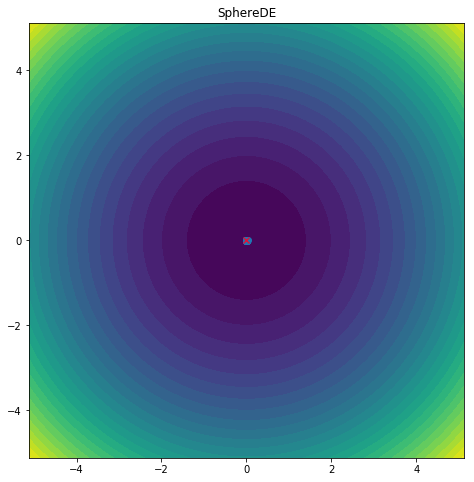

In [942]:
DifferentialEvolution(SphereFunction, global_minimum = global_minimum["Sphere"], bounds = bounds_dict["Sphere"]*2,popsize=32, file_name = "SphereDE.gif")

### ***Zakharov Function***

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.73it/s]


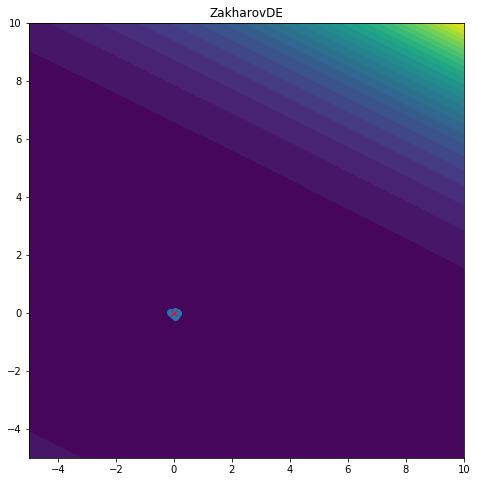

In [881]:
DifferentialEvolution(ZakharovFunction, global_minimum = global_minimum["Zakharov"], bounds = bounds_dict["Zakharov"]*2, popsize=32, file_name = "ZakharovDE.gif")

### ***RosenbrockFunction***

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  2.90it/s]


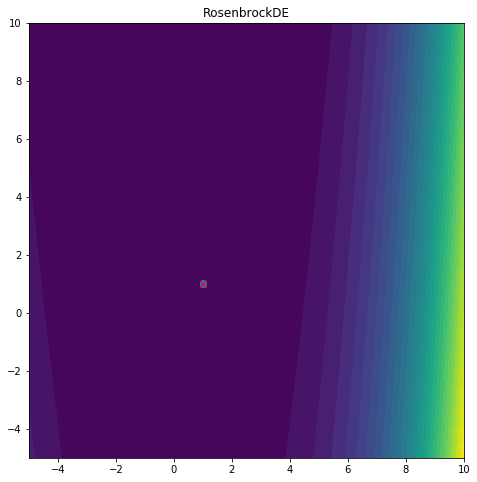

In [365]:
DifferentialEvolution(RosenbrockFunction, global_minimum = global_minimum["Rosenbrock"], bounds = bounds_dict["Rosenbrock"]*2, popsize=32, iterations=100, file_name = "RosenbrockDE.gif")

### ***MichalewiczFunction***

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.66it/s]


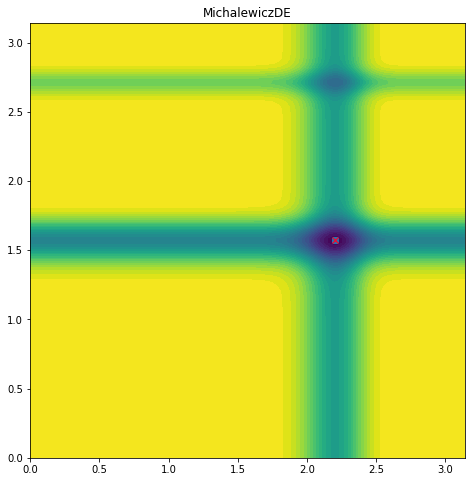

In [417]:
DifferentialEvolution(MichalewiczFunction, global_minimum = global_minimum["Michalewicz"],iterations=50, bounds = bounds_dict["Michalewicz"]*2, popsize=32, file_name = "MichalewiczDE.gif")

### ***AckleyFunction***

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.14it/s]


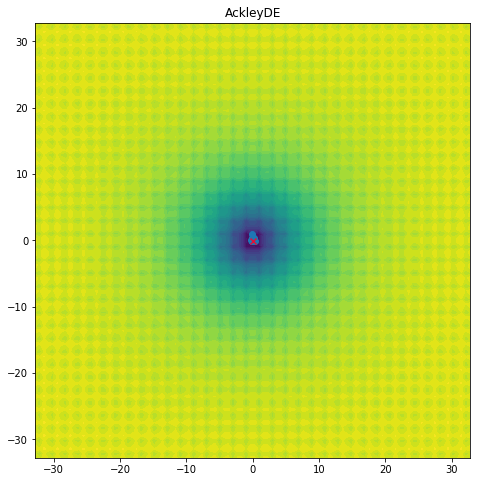

In [1487]:
DifferentialEvolution(AckleyFunction, global_minimum = global_minimum["Ackley"], bounds = bounds_dict["Ackley"]*2, popsize=32, file_name = "AckleyDE.gif")

## **CEM Improved Version Algorithm**

In [1191]:
def CEMivGIF(fobj, bounds, global_minimum, num_elite, popsize = 32, sigma_init = 1, extra_std = 0.06, iterations = 30, seed_number = 20521482, max_evals = 1e5, file_name='SphereCEM.gif'):
    np.random.seed(seed_number)
    
    results, all_fitness, all_pops, count_list, generation_count = CEMiv(fobj, bounds=bounds, num_elite=num_elite, popsize = popsize, sigma_init = sigma_init, extra_std = extra_std, seed_number = seed_number, max_evals = max_evals)
    lower_bound, upper_bound = np.asarray(bounds).T
    x = np.linspace(lower_bound[0], upper_bound[0], 100)
    y = np.linspace(lower_bound[0], upper_bound[0], 100)
    X, Y = np.meshgrid(x, y)
    Z = fobj([X, Y])

    results = np.array(results,dtype=object)
    all_pops = np.array(all_pops,dtype=object)
    fig = plt.figure(figsize=(8, 8))
    camera = Camera(fig)
    plt.contourf(X, Y, Z, popsize, cmap='viridis')
    plt.axis('square')
    plt.scatter(global_minimum[0], global_minimum[1], marker='*')
    for generation in trange(iterations):
        plt.contourf(X, Y, Z, popsize, cmap='viridis')
        plt.title(file_name[:-4])
        plt.scatter(global_minimum[0], global_minimum[1], marker='*')
        plt.scatter(all_pops[generation][:,0], all_pops[generation][:,1],c='#1f77b4')
        plt.scatter(results[generation][0],results[generation][1],c='#DC143C', marker='x')
        camera.snap()
    animation = camera.animate(interval=400,repeat=True)
    animation.save(file_name,writer="pillow")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.87it/s]


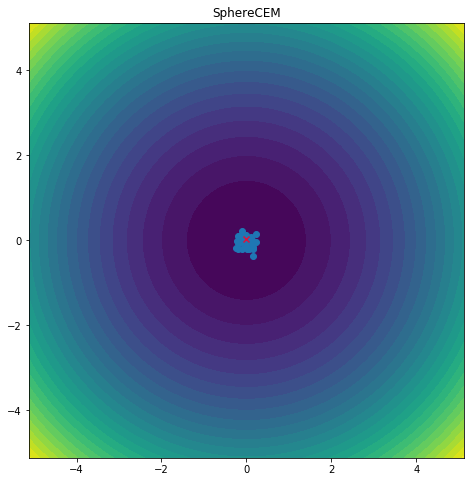

In [1223]:
CEMivGIF(SphereFunction, global_minimum = global_minimum["Sphere"], bounds=bounds_dict["Sphere"]*2, num_elite = 32//2, popsize = 32, sigma_init = 1, extra_std = 0.01, seed_number = 20521482, iterations=10, max_evals = 1e5,file_name='SphereCEM.gif')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 50.50it/s]


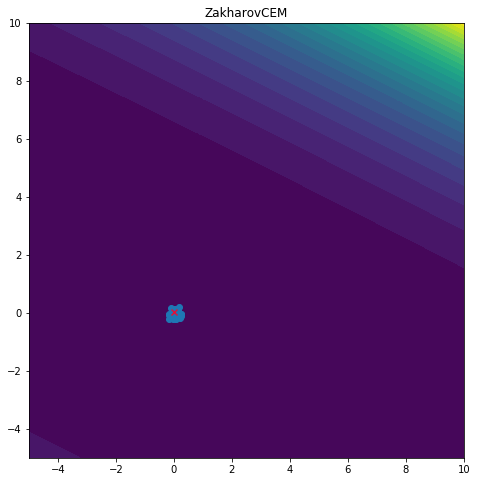

In [1224]:
CEMivGIF(ZakharovFunction, global_minimum = global_minimum["Zakharov"], bounds = bounds_dict["Zakharov"]*2, iterations = 20, num_elite = 32//2 , popsize = 32, sigma_init = 1, extra_std = 0.01, seed_number = 20521482, max_evals = 1e5,file_name='ZakharovCEM.gif')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 18.83it/s]


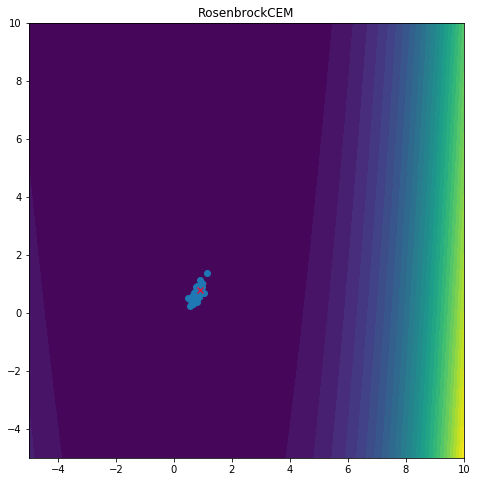

In [1222]:
CEMivGIF(RosenbrockFunction, global_minimum = global_minimum["Rosenbrock"], bounds = bounds_dict["Rosenbrock"]*2, iterations=45, num_elite = 32//2 , popsize = 32, sigma_init = 1, extra_std = 0.01, seed_number = 20521482, max_evals = 1e5,file_name='RosenbrockCEM.gif')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.94it/s]


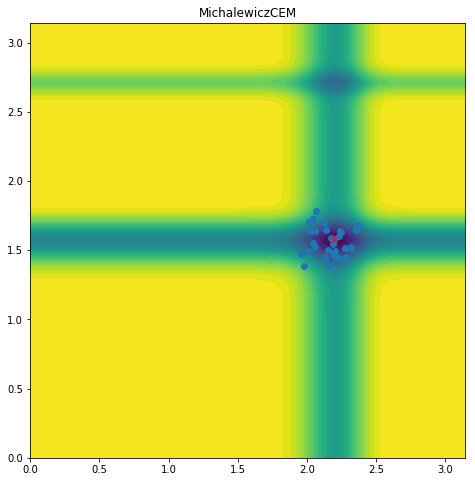

In [1238]:
CEMivGIF(MichalewiczFunction, global_minimum = global_minimum["Michalewicz"], bounds = bounds_dict["Michalewicz"]*2, num_elite = 32//2, popsize = 32, sigma_init = 1, extra_std = 0.01, seed_number = 20521482, iterations=50, max_evals = 1e5, file_name='MichalewiczCEM.gif')

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  3.84it/s]


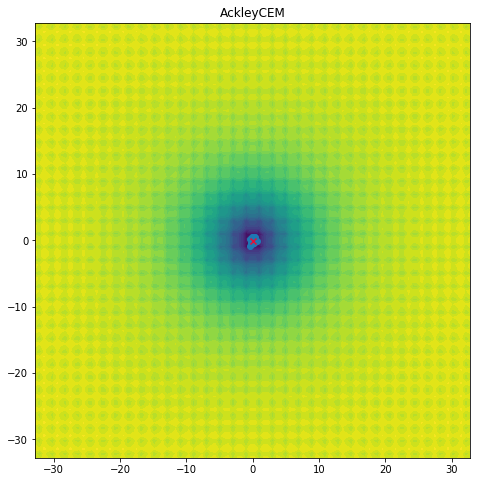

In [1488]:
CEMivGIF(AckleyFunction, global_minimum = global_minimum["Ackley"], bounds = bounds_dict["Ackley"]*2, iterations = 45, num_elite = 32//2 , popsize = 32, sigma_init = 1, extra_std = 0.06, seed_number = 20521482, max_evals = 1e5,file_name='AckleyCEM.gif')